# Análisis exploratorio de datos

Este notebook muestra como visualizar los datos 

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import locale

import matplotlib.dates as mdates
import matplotlib.ticker as mtick

from matplotlib.dates import DateFormatter
from matplotlib.ticker import Formatter, FuncFormatter
from datetime import datetime, timedelta

sns.set_context('talk')
#locale.setlocale(locale.LC_TIME, "es")

In [4]:
dataFile = '../results/afp_chile_2003_2020.csv'
today = datetime.today()

dataDF = pd.read_csv(dataFile, parse_dates=['fecha'])

dataDF = dataDF[dataDF['fecha'] > datetime(2003,1,1)]

dataDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio
7,2003-01-02,A,CUPRUM,10417.34,5.508555e+10
8,2003-01-02,A,HABITAT,10209.25,1.015109e+11
9,2003-01-02,A,MAGISTER,10331.61,6.735862e+09
10,2003-01-02,A,PLANVITAL,10430.99,4.834795e+09
11,2003-01-02,A,PROVIDA,10467.81,8.941379e+10


Eliminamos los duplicados

In [5]:
afpDF = dataDF[~dataDF.duplicated(keep='first')].copy()

dataDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio
7,2003-01-02,A,CUPRUM,10417.34,5.508555e+10
8,2003-01-02,A,HABITAT,10209.25,1.015109e+11
9,2003-01-02,A,MAGISTER,10331.61,6.735862e+09
10,2003-01-02,A,PLANVITAL,10430.99,4.834795e+09
11,2003-01-02,A,PROVIDA,10467.81,8.941379e+10


Eliminamos los fines de semana

In [6]:
businessDays = pd.bdate_range(start=afpDF['fecha'].min(), end=afpDF['fecha'].max())

afpDF = afpDF[afpDF['fecha'].isin(businessDays)]
afpDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio
7,2003-01-02,A,CUPRUM,10417.34,5.508555e+10
8,2003-01-02,A,HABITAT,10209.25,1.015109e+11
9,2003-01-02,A,MAGISTER,10331.61,6.735862e+09
10,2003-01-02,A,PLANVITAL,10430.99,4.834795e+09
11,2003-01-02,A,PROVIDA,10467.81,8.941379e+10


In [7]:
afpDF[(afpDF['administradora'] == 'HABITAT') & (afpDF['fondo'] == 'A')].head()

,fecha,fondo,administradora,valor cuota,valor patrimonio
8,2003-01-02,A,HABITAT,10209.25,1.015109e+11
15,2003-01-03,A,HABITAT,10213.08,1.015448e+11
36,2003-01-06,A,HABITAT,10273.00,1.021328e+11
43,2003-01-07,A,HABITAT,10317.50,1.025736e+11
50,2003-01-08,A,HABITAT,10398.47,1.033763e+11


Calculamos un promedio movil usando ventana de 5 y 8 dias

In [8]:
for name, group in afpDF.groupby(['fondo','administradora']):

    afpDF.loc[group.index, 'valor cuota MAV5'] = group['valor cuota'].rolling(window=5).mean()
    afpDF.loc[group.index, 'valor cuota MAV8'] = group['valor cuota'].rolling(window=8).mean()
    
afpDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio,valor cuota MAV5,valor cuota MAV8
7,2003-01-02,A,CUPRUM,10417.34,5.508555e+10,NaN,NaN
8,2003-01-02,A,HABITAT,10209.25,1.015109e+11,NaN,NaN
9,2003-01-02,A,MAGISTER,10331.61,6.735862e+09,NaN,NaN
10,2003-01-02,A,PLANVITAL,10430.99,4.834795e+09,NaN,NaN
11,2003-01-02,A,PROVIDA,10467.81,8.941379e+10,NaN,NaN


Calculamos las rentabilidades

In [9]:
paymentAFP = 60000
paymentSchedule = pd.date_range(start=datetime(2003,1,1), end=datetime(2020,7,1), freq='M')
#paymentSchedule = pd.date_range(start=datetime(2007,10,1), end=datetime(2020,7,1), freq='M')

for name, group in afpDF.groupby(['fondo','administradora']):
    
    # rentabilidad YTD
    refValue = group.iloc[0]['valor cuota']
    afpDF.loc[group.index, 'rentabilidad YTD'] = (group['valor cuota'] / refValue) - 1        

    # rentabilidad diaria
    afpDF.loc[group.index, 'rentabilidad diaria'] = (group['valor cuota'] / group['valor cuota'].shift(1)) - 1

    # rentabilidad media 5
    afpDF.loc[group.index, 'rentabilidad MAV5'] = (group['valor cuota MAV5'] / group['valor cuota MAV5'].shift(1)) - 1
    
    # rentabilidad media 8
    afpDF.loc[group.index, 'rentabilidad MAV8'] = (group['valor cuota MAV8'] / group['valor cuota MAV8'].shift(1)) - 1
    
    investmentPesos=0
    savingsPesos=0
    savingsStocks=0
    for paymentDay in paymentSchedule:
        diff = group['fecha'] - paymentDay
        diff = diff[diff >= timedelta(days=0)]
        
        if len(diff)>0:
            idx = diff.index[0]
            savingsPesos = savingsStocks*group.loc[idx, 'valor cuota'] + paymentAFP
            savingsStocks += paymentAFP/group.loc[idx, 'valor cuota']
            afpDF.loc[idx, 'ahorro pesos'] = savingsPesos
            
            investmentPesos += paymentAFP
            afpDF.loc[idx, 'inversion pesos'] = investmentPesos
    
afpDF.head()

,fecha,fondo,administradora,valor cuota,valor patrimonio,valor cuota MAV5,valor cuota MAV8,rentabilidad YTD,rentabilidad diaria,rentabilidad MAV5,rentabilidad MAV8,ahorro pesos,inversion pesos
7,2003-01-02,A,CUPRUM,10417.34,5.508555e+10,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
8,2003-01-02,A,HABITAT,10209.25,1.015109e+11,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
9,2003-01-02,A,MAGISTER,10331.61,6.735862e+09,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
10,2003-01-02,A,PLANVITAL,10430.99,4.834795e+09,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN
11,2003-01-02,A,PROVIDA,10467.81,8.941379e+10,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN


# Creamos funciones para visualizar los datos

In [10]:
#Obtained from mplfinance https://github.com/matplotlib/mplfinance

class IntegerIndexDateTimeFormatter(Formatter):
    """
    Formatter for axis that is indexed by integer, where the integers
    represent the index location of the datetime object that should be
    formatted at that lcoation.  This formatter is used typically when
    plotting datetime on an axis but the user does NOT want to see gaps
    where days (or times) are missing.  To use: plot the data against
    a range of integers equal in length to the array of datetimes that
    you would otherwise plot on that axis.  Construct this formatter
    by providing the arrange of datetimes (as matplotlib floats). When
    the formatter receives an integer in the range, it will look up the
    datetime and format it.  
    """
    
    def __init__(self, dates, fmt='%d %b, %H:%M'):
        self.dates = dates
        self.len   = len(dates)
        self.fmt   = fmt

    def __call__(self, x, pos=0):
        #import pdb; pdb.set_trace()
        'Return label for time x at position pos'
        # not sure what 'pos' is for: see
        # https://matplotlib.org/gallery/ticks_and_spines/date_index_formatter.html
        ix = int(np.round(x))
         
        if ix >= self.len or ix < 0:
            date = None
            dateformat = ''
        else:
            date = self.dates[ix]
            dateformat = mdates.num2date(date).strftime(self.fmt)
        
        return dateformat

In [11]:
def plotValue(dataDF, companyName='HABITAT', dataX='fecha', dataY='valor cuota', dataHue='fondo'):
    
    today = datetime.today()
    companyName = companyName.upper()
    plotDF = dataDF[(dataDF['administradora'] == companyName)].copy()
    plotDF['dateNum'] = mdates.date2num(plotDF[dataX].dt.to_pydatetime())

    fig, ax = plt.subplots(figsize = (16,8))
    sns.lineplot(x=dataX, y=dataY, hue=dataHue,
                 data=plotDF, ax=ax)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.suptitle('{} - AFP {}'.format(dataY.title(), companyName.title()), fontsize='large')
    ax.set_xlabel(dataX, fontsize='medium')
    ax.set_ylabel(dataY, fontsize='medium')
    ax.set_xlim(left=datetime(today.year, 1, 1))

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.xaxis.set_tick_params(rotation=45)
    ax.xaxis.grid(True, linestyle='--')
    
    
def plotReturn(dataDF, companyName='HABITAT', dataX='fecha', dataY='rentabilidad YTD', dataHue='fondo'):
    
    today = datetime.today()
    companyName = companyName.upper()
    plotDF = dataDF[(dataDF['administradora'] == companyName)]

    fig, ax = plt.subplots(figsize = (16,8))
    sns.lineplot(x=dataX, y=dataY, hue=dataHue,
                 data=plotDF, ax=ax)

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    fig.suptitle('{} - AFP {}'.format(dataY.title(), companyName.title()), fontsize='large')
    ax.set_xlabel(dataX, fontsize='medium')
    ax.set_ylabel(dataY, fontsize='medium')
    ax.set_xlim(left=datetime(today.year, 1, 1))

    ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.MO, interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d %b'))
    ax.xaxis.set_tick_params(rotation=45)
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    ax.xaxis.grid(True, linestyle='--')
    plt.axhline(0, linestyle='--', linewidth=1, color='black')

In [12]:
def plotBDValue(dataDF, companyName='HABITAT', dataX='fecha', dataY='valor cuota', dataHue='fondo', weekSteps=1,
                plotTitle=None, plotInvestment=False, plotRange=None):
    
    today = datetime.today()
    companyName = companyName.upper()
    plotDF = dataDF[(dataDF['administradora'] == companyName)].copy()
    
    if plotRange is not None:
        plotDF = plotDF[ (plotDF['fecha'] >= plotRange[0]) & (plotDF['fecha'] <= plotRange[1]) ]
    
    #We compute the plot limits using the nearest mondays
    if weekSteps == 1:
        mondays = pd.date_range(plotDF[dataX].min(), plotDF[dataX].max(), freq="W-MON")
        
        if plotDF[dataX].min() != mondays[0]:
            plotDateMin = mondays[0] - timedelta(days=7)
        else:
            plotDateMin = mondays[0]

        if plotDF[dataX].max() != mondays[-1]:
            plotDateMax = mondays[-1] + timedelta(days=7)
        else:
            plotDateMax = mondays[-1]
        
    else:
        mondays = pd.Series(pd.date_range(plotDF[dataX].min(), plotDF[dataX].max(), freq="W-MON"))
        mondays = mondays.iloc[::weekSteps]
        
        if plotDF[dataX].min() != mondays[0]:
            plotDateMin = mondays[0] - timedelta(days=7)
        else:
            plotDateMin = mondays[0]

        if plotDF[dataX].max() != mondays.iloc[-1]:
            plotDateMax = mondays.iloc[-1] + timedelta(days=weekSteps*7)
        else:
            plotDateMax = mondays[-1]       
        
    #We convert dates into integer indexes
    businessdays = pd.bdate_range(plotDateMin, plotDateMax)
    for name, group in plotDF.groupby(['fondo']):
        plotDF.loc[group.index, 'dateIdx'] = np.where( businessdays.isin(group[dataX]) )[0]

    if weekSteps == 1:
        mondays = pd.date_range(plotDateMin, plotDateMax, freq="W-MON")
    else:
        mondays = pd.Series(pd.date_range(plotDateMin, plotDateMax, freq="W-MON"))
        mondays = mondays.iloc[::weekSteps]

    plotDate = businessdays.to_pydatetime()
    plotDateNum = mdates.date2num(plotDate)
    plotTicks = np.where( businessdays.isin(mondays) )[0]

    fmtString = '%d %b %y'
    formatter = IntegerIndexDateTimeFormatter(plotDateNum, fmtString)
            
    fig, ax = plt.subplots(figsize = (16,8))
    sns.lineplot(x='dateIdx', y=dataY, hue=dataHue, data=plotDF, ax=ax)
    

    if isinstance(plotTitle, str):
        fig.suptitle(plotTitle, fontsize='large')
    else:
        fig.suptitle('{} - AFP {}'.format(dataY.title(), companyName.title()), fontsize='large')

    if plotInvestment:
#        print(plotDF['inversion pesos'])
#        plt.plot(plotDF['dateIdx'], plotDF['inversion pesos'], '-')
        sns.lineplot(x='dateIdx', y='inversion pesos', color='black', linewidth=2.,
                     data=plotDF, ax=ax, label='Contribución 10%')
        ax.lines[5].set_linestyle("--")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
    ax.set_xlabel(dataX, fontsize='medium')
    ax.set_ylabel(dataY, fontsize='medium')
    ax.set_xlim(plotTicks[0], plotTicks[-1])

    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_ticks(plotTicks)
    ax.xaxis.set_tick_params(rotation=80)
    ax.xaxis.grid(True, linestyle='--')
    
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, p: format(int(x), ',')))
    

def plotBDReturn(dataDF, companyName='HABITAT', dataX='fecha', dataY='rentabilidad YTD', dataHue='fondo', weekSteps=1, plotTitle=None):
    
    today = datetime.today()
    companyName = companyName.upper()
    plotDF = dataDF[(dataDF['administradora'] == companyName)].copy()
           
    #We compute the plot limits using the nearest mondays
    if weekSteps == 1:
        mondays = pd.date_range(plotDF[dataX].min(), plotDF[dataX].max(), freq="W-MON")
        
        if plotDF[dataX].min() != mondays[0]:
            plotDateMin = mondays[0] - timedelta(days=7)
        else:
            plotDateMin = mondays[0]

        if plotDF[dataX].max() != mondays[-1]:
            plotDateMax = mondays[-1] + timedelta(days=7)
        else:
            plotDateMax = mondays[-1]
        
    else:
        mondays = pd.Series(pd.date_range(plotDF[dataX].min(), plotDF[dataX].max(), freq="W-MON"))
        mondays = mondays.iloc[::weekSteps]
        
        if plotDF[dataX].min() != mondays[0]:
            plotDateMin = mondays[0] - timedelta(days=7)
        else:
            plotDateMin = mondays[0]

        if plotDF[dataX].max() != mondays.iloc[-1]:
            plotDateMax = mondays.iloc[-1] + timedelta(days=weekSteps*7)
        else:
            plotDateMax = mondays[-1] 
    
    businessdays = pd.bdate_range(plotDateMin, plotDateMax)
    for name, group in plotDF.groupby(['fondo']):
        plotDF.loc[group.index, 'dateIdx'] = np.where( businessdays.isin(group[dataX]) )[0]

    if weekSteps == 1:
        mondays = pd.date_range(plotDateMin, plotDateMax, freq="W-MON")
    else:
        mondays = pd.Series(pd.date_range(plotDateMin, plotDateMax, freq="W-MON"))
        mondays = mondays.iloc[::weekSteps]
        
    plotDate = businessdays.to_pydatetime()
    plotDateNum = mdates.date2num(plotDate)
    plotTicks = np.where( businessdays.isin(mondays) )[0]

    fmtString = '%d %b %y'
    formatter = IntegerIndexDateTimeFormatter(plotDateNum, fmtString)
    
    fig, ax = plt.subplots(figsize = (16,8))
    sns.lineplot(x='dateIdx', y=dataY, hue=dataHue,
                 data=plotDF, ax=ax)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    if isinstance(plotTitle, str):
        fig.suptitle(plotTitle, fontsize='large')
    else:
        fig.suptitle('{} - AFP {}'.format(dataY.title(), companyName.title()), fontsize='large')
    ax.set_xlabel(dataX, fontsize='medium')
    ax.set_ylabel(dataY, fontsize='medium')
    ax.set_xlim(plotTicks[0], plotTicks[-1])

    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.set_ticks(plotTicks)
    ax.xaxis.set_tick_params(rotation=80)
    ax.xaxis.grid(True, linestyle='--')
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    
    plt.axhline(0, linestyle='--', linewidth=1, color='black')

# AFP Habitat

## Análisis de valor cuota

In [13]:
#plotValue(afpDF, companyName='habitat', dataX='fecha', dataY='valor cuota')

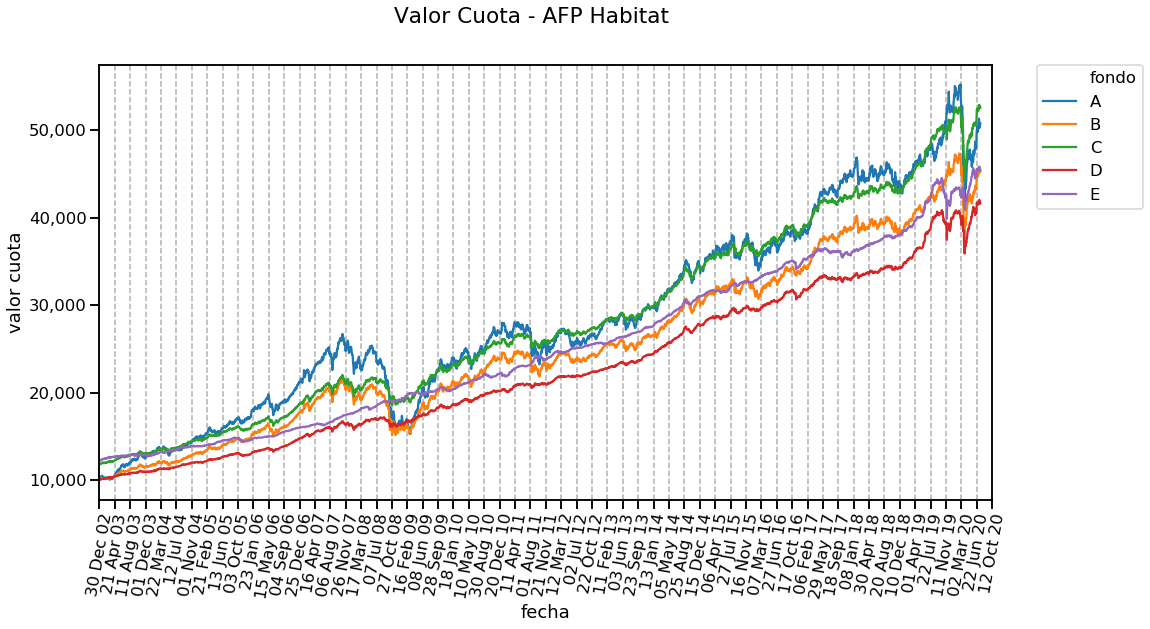

In [14]:
plotBDValue(afpDF, companyName='habitat', dataX='fecha', dataY='valor cuota', weekSteps=16)

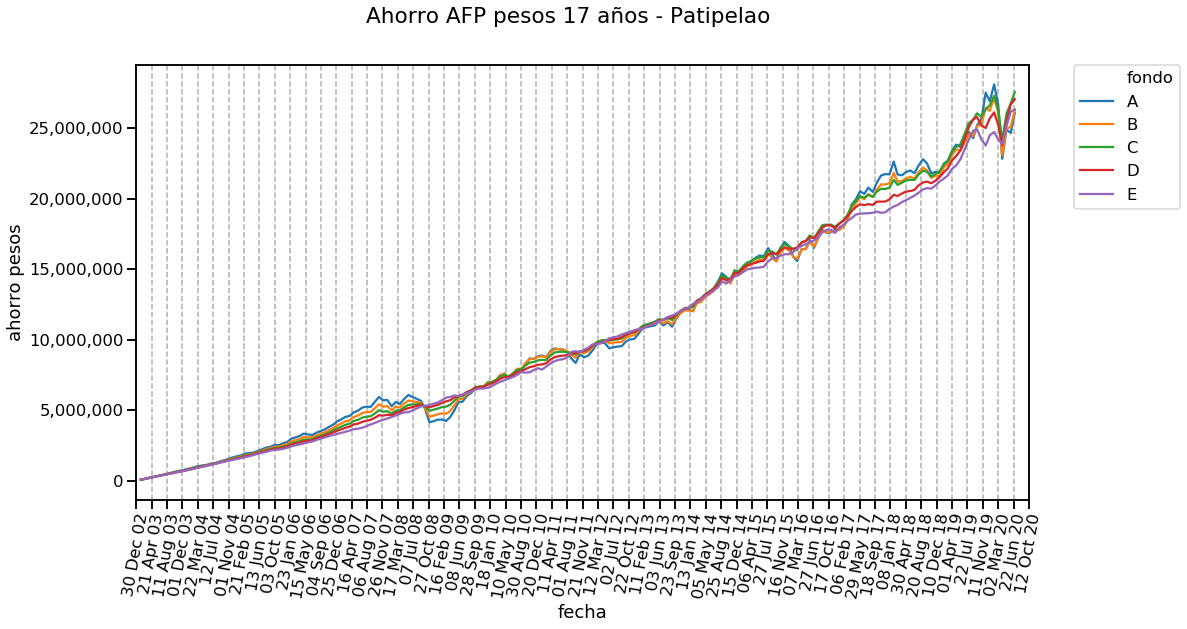

In [16]:
plotRange=None #[datetime(2019,1,1), datetime(2020,7,30)] 
plotBDValue(afpDF, companyName='habitat', dataX='fecha', dataY='ahorro pesos', weekSteps=16, plotTitle='Ahorro AFP pesos 17 años - Patipelao', plotInvestment=False, plotRange=plotRange)

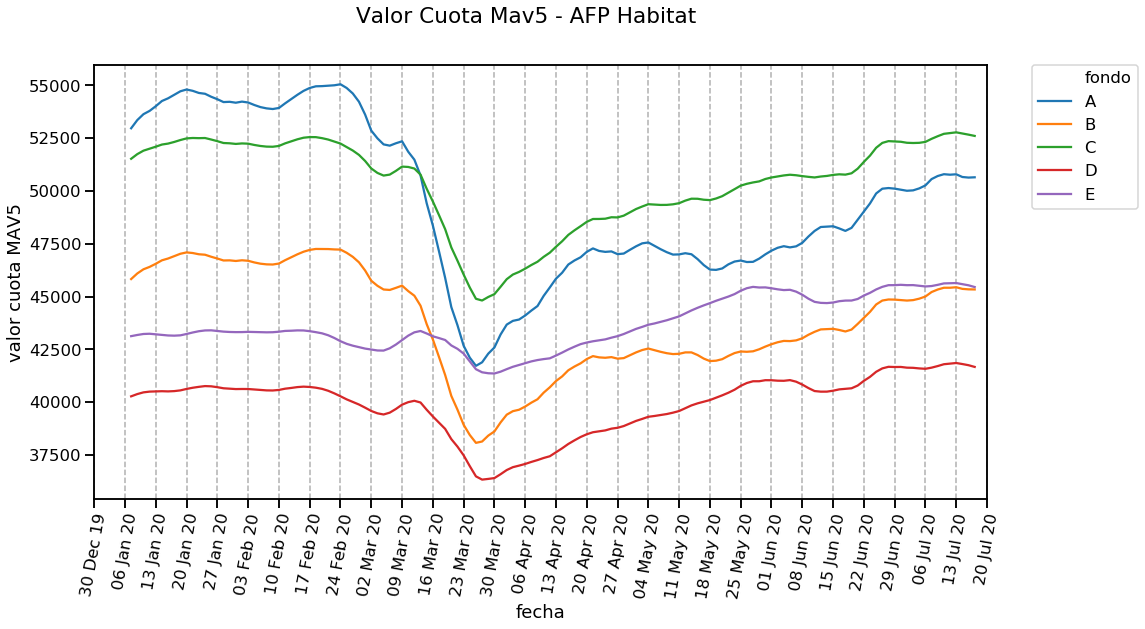

In [327]:
plotBDValue(afpDF, companyName='habitat', dataX='fecha', dataY='valor cuota MAV5', weekSteps=1)

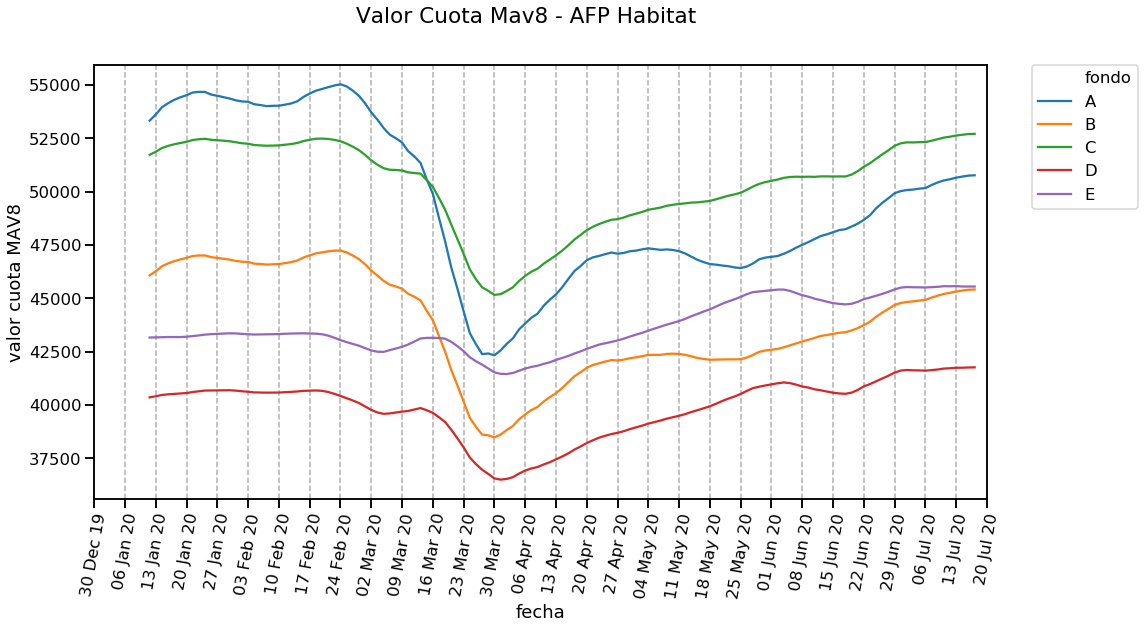

In [328]:
plotBDValue(afpDF, companyName='habitat', dataX='fecha', dataY='valor cuota MAV8', weekSteps=1)

## Análisis de rentabilidad

Rentabilidad YTD

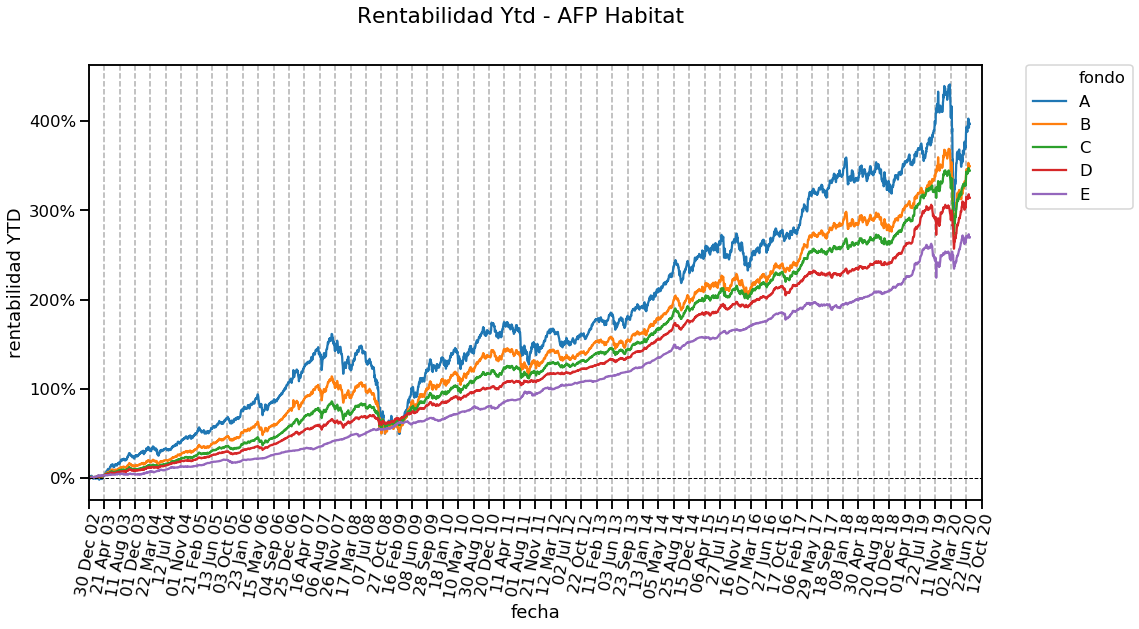

In [18]:
plotBDReturn(afpDF, companyName='habitat', dataX='fecha', dataY='rentabilidad YTD', weekSteps=16)

Rentabilidad Simple moving average 5 days

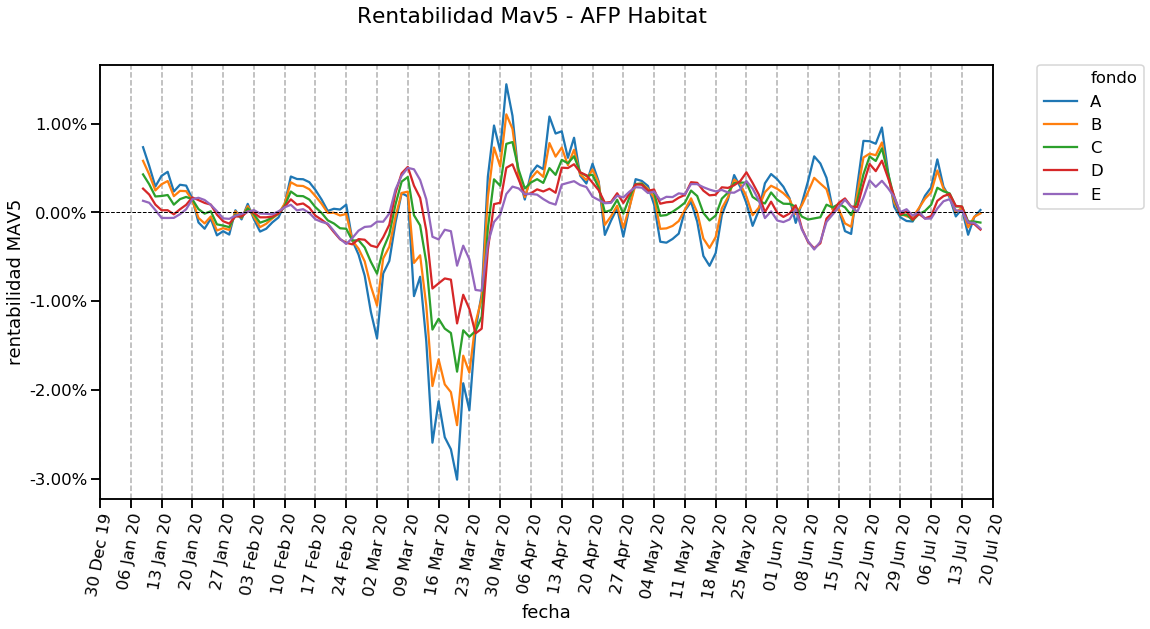

In [331]:
plotBDReturn(afpDF, companyName='habitat', dataX='fecha', dataY='rentabilidad MAV5', weekSteps=1)

Rentabilidad Simple moving average 8 days

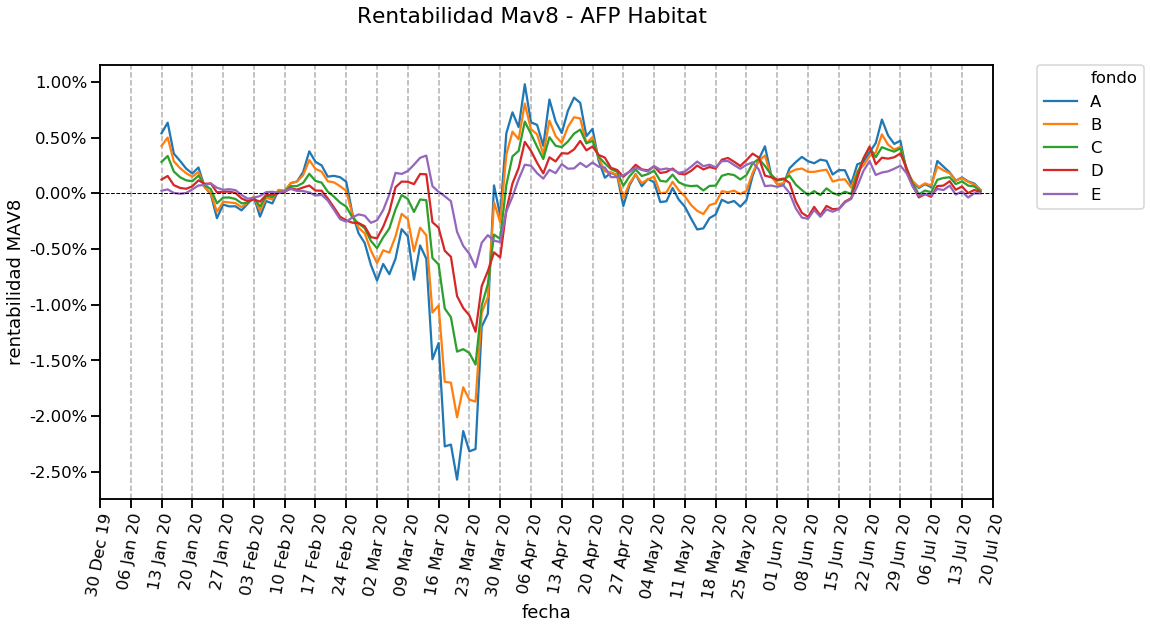

In [332]:
plotBDReturn(afpDF, companyName='habitat', dataX='fecha', dataY='rentabilidad MAV8', weekSteps=1)

# AFP Capital

## Análisis de rentabilidad

Rentabilidad YTD

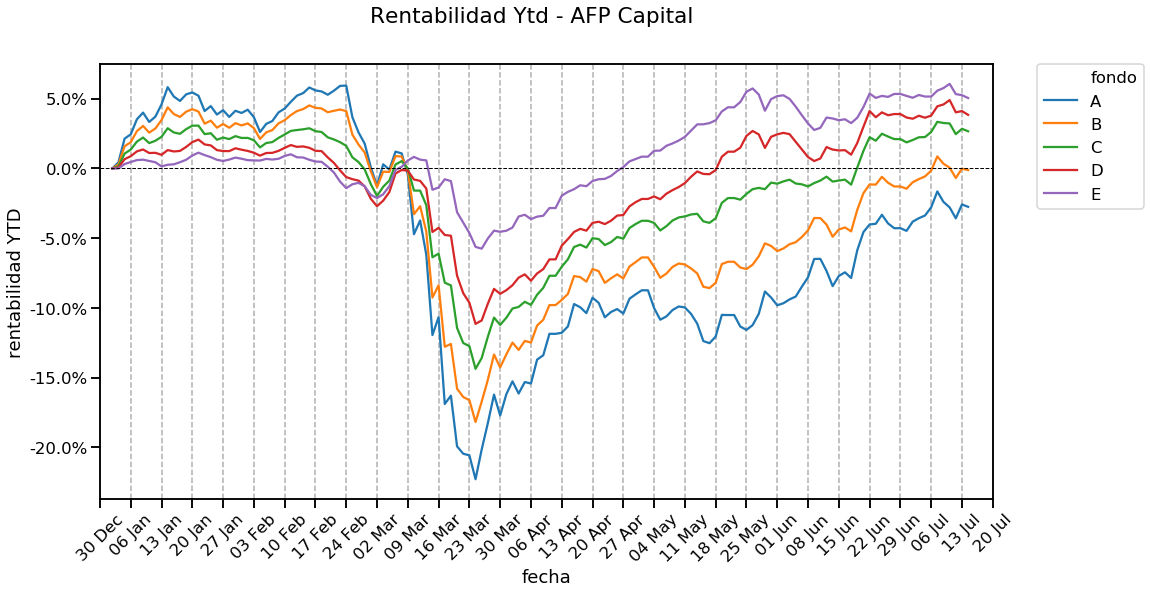

In [87]:
plotBDReturn(afpDF, companyName='capital', dataX='fecha', dataY='rentabilidad YTD')

Rentabilidad Simple moving average 5 days

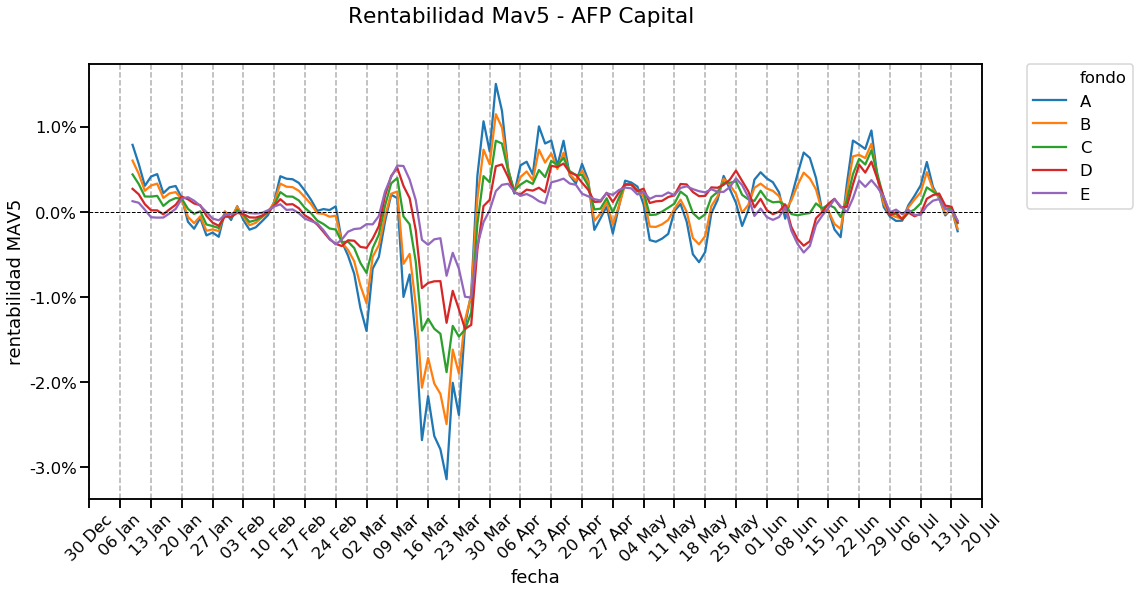

In [88]:
plotBDReturn(afpDF, companyName='capital', dataX='fecha', dataY='rentabilidad MAV5')

Rentabilidad Simple moving average 8 days

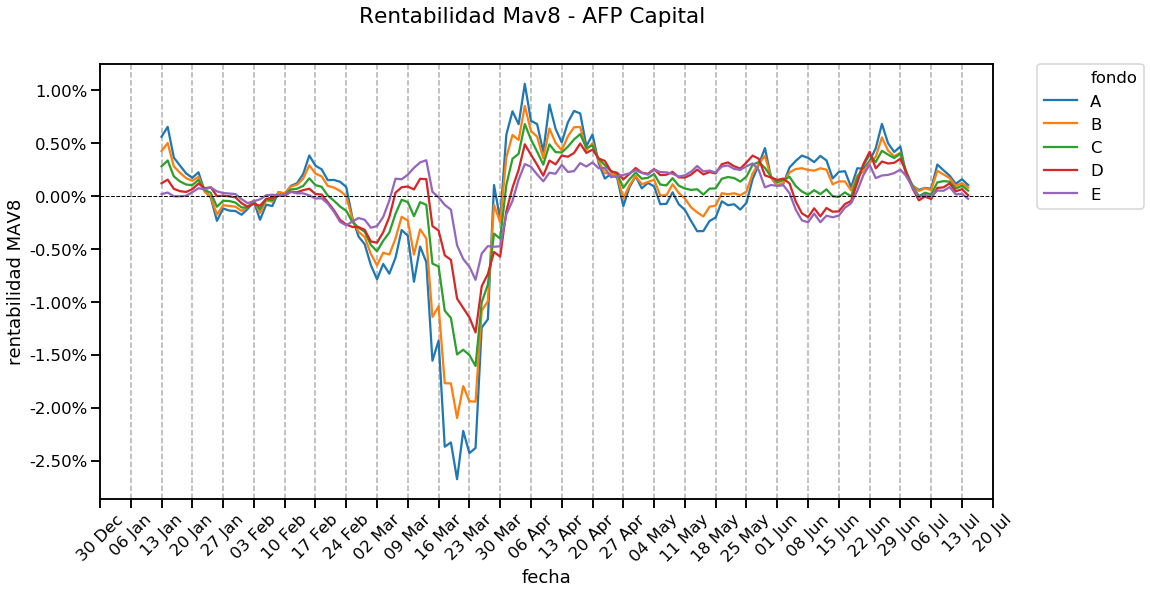

In [89]:
plotBDReturn(afpDF, companyName='capital', dataX='fecha', dataY='rentabilidad MAV8')

# AFP Plan Vital

## Análisis de rentabilidad

Rentabilidad YTD

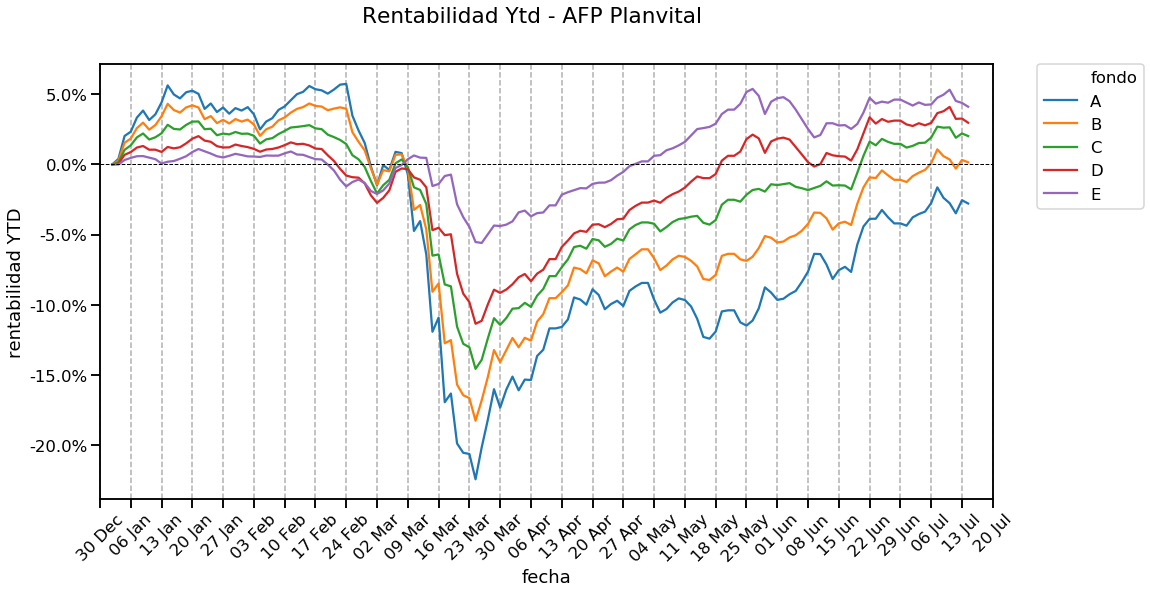

In [90]:
plotBDReturn(afpDF, companyName='planvital', dataX='fecha', dataY='rentabilidad YTD')

Rentabilidad Simple moving average 5 days

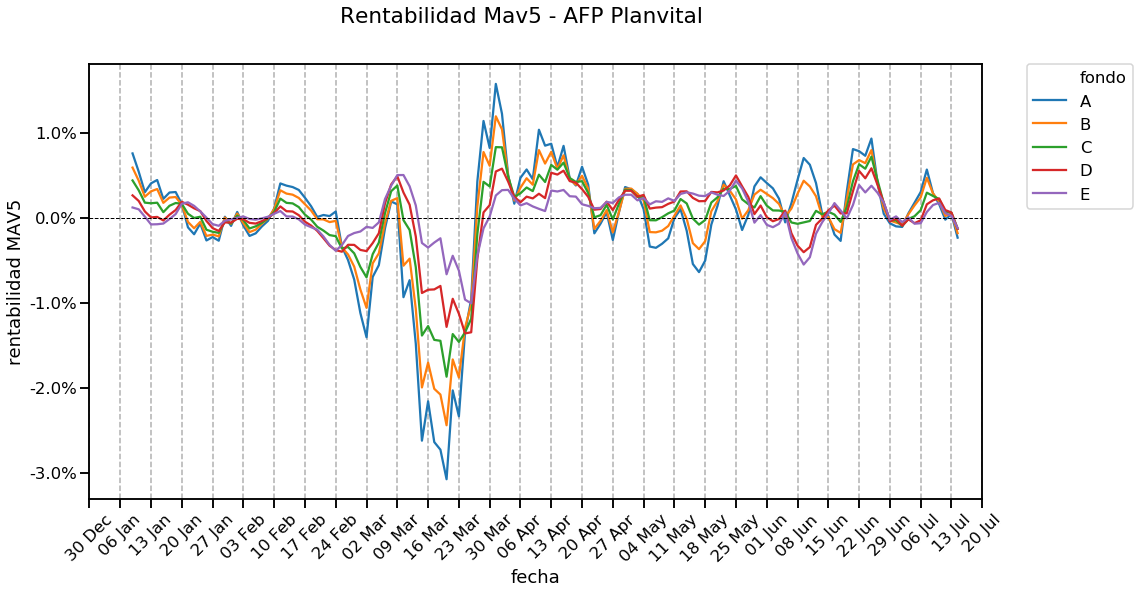

In [91]:
plotBDReturn(afpDF, companyName='planvital', dataX='fecha', dataY='rentabilidad MAV5')

Rentabilidad Simple moving average 8 days

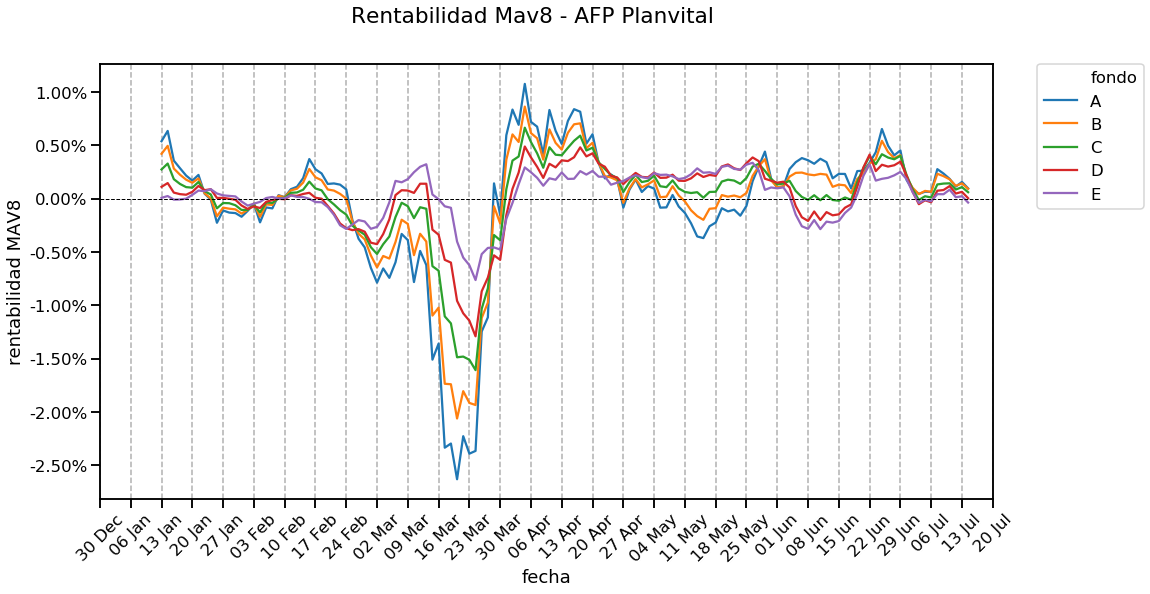

In [92]:
plotBDReturn(afpDF, companyName='planvital', dataX='fecha', dataY='rentabilidad MAV8')